# Netflix Prize Data Analysis

Data is published by Netflix in order to create a recommendation model for their movies. Data consists of 4 separated data files of training data and 2 more files (probe and qualifying) to work on and make predictions.

We are mostly interested in the training data in order to understand, prepare and analyze possible connections.

Before we start, let's import the packages we will need on the way.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Import and Wrangling

Each of the 4 trainigg data files are pretty big and includes:

- MovieIDs 
- CustomerIDs 
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

In addition, there exists another .csv file with the movie titles and release dates. This will help us connect the movieIDs to the titles for better understanding of which movie we talk about.

We will import each of the files separately and then join them to one big dataframe.

In [3]:
df1 = pd.read_table("Desktop\\NetflixData\\combined_data_1.txt",
                    sep = ",",
                    nrows=1000000,
                    names = ['customer_id', 'rating', 'date'],
                    #usecols = [0,1],                    
                    engine = 'python')

df1.head(5)

,customer_id,rating,date
0,1:,NaN,None
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


As can be seen the data is not really organized and comfortable to work with. Thus, first we will clean it and organize it in.

First of all, we will create 'movieID' column that will tell us specifically which movie was rated in each row instead of just in the beginning (or in the middle of the dataframe where we can't really know or use the information).

In [4]:
#Create a function to create a 'movieID' column with the specific movie of each rating

def movieid_col(df, first_movie):
    #The only missing values we have are the frist row starting a new movie ID. 
    #Find the rows with missing values in Rating column
    null = df[df["rating"].isnull()].reset_index()
    
    #Initiate the variables for data organization.
    #Create an empty array to fill up later with movies of each row
    movie_arr=np.array([])
    
    #Movie ID is sequential in the files starting from 1 in the first file.
    #Take the first movie in each file. The first movie of each file is +1 of the last movie of the file before.
    movie = first_movie
    
    #Initiate the iterating variable for loop
    i=1
    
    #Create a for loop that goes over each index with a missing value and fill it up with the movie ID until 
    #it meets another missing value on the list
    for i in range(1,len(null['index'])):
        helper_arr = np.full((1, null['index'].iloc[i] - null['index'].iloc[i-1]), movie)
        movie_arr = np.append(movie_arr,helper_arr)
        movie = movie + 1
    
    #Take care of the last movie ID that is not completed because of the for loop boundaries
    last = np.full((1, len(df) - null['index'].iloc[-1]), movie)
    movie_arr = np.append(movie_arr,last)
    
    #Take the last movie ID of the file to use for the next data file
    last_movie = movie
    
    #Finally, create a new column in dataframe with the movie array filled with the movie IDs according to the rows
    df['movieID'] = movie_arr.astype(int)
    
    #For checking purposes print the last movie of the file
    return last_movie

In [5]:
#Create movieID column and save the last movie checked as a variable for further use
last_movie = movieid_col(df1, 1)

Now that we created a new column so that we have the movie ID of each rating, we can get rid of the rows that were the movieIDs in the first place (ex: customer_id = '5:') as they are not really data points for us anymore.

In [6]:
#Keep only the rows where 'rating' column is not NaN
df1 = df1[df1["rating"].notnull()]

In [7]:
#Check the final dataframe
df1.head(5)

,customer_id,rating,date,movieID
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


After finally having a clean dataframe we can load the other 3 data files and do the same type of manipulation to each of them right after the reading.

In [8]:
#Load and organize the second data file
#df2 = pd.read_table("Desktop\\NetflixData\\combined_data_2.txt",
#                    sep = ",",
#                    names = ['customer_id', 'rating', 'date'],                  
#                    engine = 'python')

#df2.head(5)
#last_movie = movieid_col(df2, last_movie+1)
#df2 = df2[df2["rating"].notnull()]

#Load and organize the third data file
#df3 = pd.read_table("Desktop\\NetflixData\\combined_data_3.txt",
#                    sep = ",",
#                    names = ['customer_id', 'rating', 'date'],                  
#                    engine = 'python')

#df3.head(5)
#last_movie = movieid_col(df3, last_movie+1)
#df3 = df3[df3["rating"].notnull()]

#Load and organize the fourth data file
#df4 = pd.read_table("Desktop\\NetflixData\\combined_data_4.txt",
#                    sep = ",",
#                    names = ['customer_id', 'rating', 'date'],                  
#                    engine = 'python')

#df4.head(5)
#last_movie = movieid_col(df4, last_movie+1)
#df4 = df4[df4["rating"].notnull()]



Once we have all files imported, we can finally concatenate all of them to get one full dataframe. 

In [9]:
#Join all the data together to get the full training data
#fulldf = pd.concat([df1, df2, df3,df4], ignore_index= True)

#Check the numbers add up
#if len(df1)+len(df2)+len(df3)+len(df4) == len(fulldf):
#    print('The concatenation was succesfull!')

Because of the very big size of each dataframe (let alone the full one) and the insufficient memory of the computer, we will go on with our analysis using only the first dataframe (df1) of 1M rows.

## More Data Wrangling

As we all know, just seeing the ID of a movie is not as exciting as actually knowing what that movie is. Hence we will import another dataframe with the movie IDs and titles (as well as year of release) and add that to our dataframe.

NOTE: Because we are only analysing df1, we will only load the relevant part of the movie titles to speed up the process.

In [10]:
movies = pd.read_csv("Desktop\\NetflixData\\movie_titles.csv",
                    sep = ",",
                    usecols = [0,2],
                    nrows = last_movie,
                    names = ['movieID', 'title'],                  
                    engine = 'python')

In [11]:
#Merge the 2 dataframes
finaldf = pd.merge(df1, movies, on = 'movieID')

#Reorder the columns for more intuitive view
finaldf = finaldf[['movieID', 'title', 'customer_id', 'rating', 'date']]

In [12]:
#Show the final dataframe
finaldf.head(5)

,movieID,title,customer_id,rating,date
0,1,Dinosaur Planet,1488844,3.0,2005-09-06
1,1,Dinosaur Planet,822109,5.0,2005-05-13
2,1,Dinosaur Planet,885013,4.0,2005-10-19
3,1,Dinosaur Planet,30878,4.0,2005-12-26
4,1,Dinosaur Planet,823519,3.0,2004-05-03


## Data Analysis

We can start analyzing the after cleansing it and getting it ready for.

In [13]:
#Basic information on the dataset

#Find the movie count
movie_cnt = len(finaldf['title'].unique())

#Users
user_cnt = len(finaldf['customer_id'].unique())

#Total ratings
rating_cnt = len(finaldf)

print(str(movie_cnt) + ' movies were rated by ' + str(user_cnt) +' users with a total of ' + str(rating_cnt) + ' reviews')

225 movies were rated by 283670 users with a total of 999775 reviews


In [14]:
ratings = finaldf[['rating', 'customer_id']]\
         .groupby('rating', as_index = False)\
         .count()\
         .rename(columns = ({'customer_id' : '#rating'}))

In [15]:
ratings

,rating,#rating
0,1.0,44851
1,2.0,96545
2,3.0,277190
3,4.0,351854
4,5.0,229335


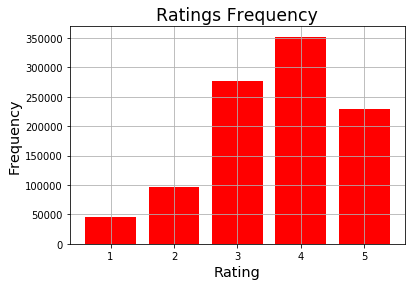

In [16]:
#Create bar plot
ax = plt.bar(np.arange(len(ratings['rating'])), ratings['#rating'], tick_label = ratings['rating'].astype(int), color = 'red')

plt.xlabel("Rating", fontsize = 'x-large')
plt.ylabel("Frequency", fontsize = 'x-large')
plt.title("Ratings Frequency", fontsize = 'xx-large')
plt.grid()
    
plt.show()

It can be seen that most of the movies are between average (rating 3) to good (rating 4).

Now let's check some rating statistics of the dataframe according to each movie.

In [17]:
rating_stats = finaldf.pivot_table(values = ['rating'], index = ['title'], 
                                   aggfunc = {'rating' : [min, max, 'mean', 'std', 'count']})

rating_stats

rating                      \
                                                    count  max      mean  min   
title                                                                           
6ixtynin9                                             388  5.0  3.185567  1.0   
7 Seconds                                            7108  5.0  2.903208  1.0   
8 Man                                                  93  5.0  2.129032  1.0   
A Fishy Story                                         126  5.0  2.420635  1.0   
A Killer Within                                       374  5.0  2.657754  1.0   
A Little Princess                                    9162  5.0  3.934076  1.0   
A Yank in the R.A.F.                                  328  5.0  3.027439  1.0   
ABC Primetime: Mel Gibson's The Passion of the ...   1854  5.0  4.071737  1.0   
Adam-12: Season 1                                     191  5.0  3.319372  1.0   
Airplane II: The Sequel                             14137  5.0  3.346467  1.0   
Allergies: A Natural Approach                          96  5.0  2.510417  1.0   
Antarctica: IMAX                                     1249  5.0  3.439552  1.0   
Aqua Teen Hunger Force: Vol. 1                       6890  5.0  4.168650  1.0   
Arachnid                                              705  5.0  2.695035  1.0   
Arliss: The Best of Arliss                            646  5.0  3.134675  1.0   
Ashtanga Yoga: Beginner's Practice with Nicki D...    108  5.0  2.712963  1.0   
At Home Among Strangers                               179  5.0  3.145251  1.0   
Barbarian Queen 2                                     166  5.0  2.295181  1.0   
Bear Cub                                             1126  5.0  3.539076  1.0   
Beyonce: Live at Wembley                               99  5.0  3.616162  1.0   
Billy Blanks: Tae Bo: Cardio Circuit 1                399  5.0  3.338346  1.0   
Blood and Sand                                        104  5.0  2.096154  1.0   
Bollywood Bound                                       286  5.0  2.458042  1.0   
Boycott                                               523  5.0  3.598470  1.0   
Bruce Lee: A Warrior's Journey                       1393  5.0  3.885140  1.0   
By Dawn's Early Light                                 539  5.0  3.324675  1.0   
Cannibal Women in the Avocado Jungle of Death         366  5.0  2.420765  1.0   
Carandiru                                            1833  5.0  3.648663  1.0   
Cartoon Network Halloween: 9 Creepy Cartoon Capers    335  5.0  3.388060  1.0   
Cat and the Canary                                    120  5.0  2.975000  1.0   
...                                                   ...  ...       ...  ...   
The Libertine                                         295  5.0  2.149153  1.0   
The Love Letter                                      2619  5.0  2.968690  1.0   
The Powerpuff Girls Movie                            2752  5.0  3.221294  1.0   
The Rise and Fall of ECW                             1140  5.0  3.919298  1.0   
The SoulTaker                                         275  5.0  3.200000  1.0   
The Strongest Man in the World                        980  5.0  3.596939  1.0   
The Three Stooges: Sing a Song of Six Pants          2196  5.0  3.358834  1.0   
The Tricky Master                                     326  5.0  2.809816  1.0   
The Weather Underground                              5147  5.0  3.757140  1.0   
They Came Back                                        174  5.0  2.689655  1.0   
Tomorrow                                              215  5.0  3.181395  1.0   
Travel the World by Train: Africa                      96  5.0  2.697917  1.0   
Triumph: Live at the US Festival                      115  5.0  3.226087  1.0   
Troy: Bonus Material                                  513  5.0  3.302144  1.0   
Unconstitutional: The War on Our Civil Liberties     1096  5.0  3.858577  1.0   
Vampire Effect (aka Twins Effect)                    1184  5.0  3.201858  1.0   
V

Let's check the top 10 movies according to their average ratings. (Keep in mind that we don't take into acccount the number of reviews, yet)

In [18]:
top10 = rating_stats['rating', 'mean'].sort_values(ascending = False)[:10].to_frame()
top10

,rating
,mean
title,
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material,4.552000
Elfen Lied,4.251880
Chappelle's Show: Season 1,4.211192
Aqua Teen Hunger Force: Vol. 1,4.168650
Star Trek: Deep Space Nine: Season 5,4.160759
Invader Zim,4.142599
GTO: Great Teacher Onizuka: Set 2,4.138021
Stevie Ray Vaughan and Double Trouble: Live at Montreux 1982 & 1985,4.097872


Now we will remove the movies with less than 500 reviews and check how the top 10 changes accordingly.

In [19]:
top10new = rating_stats[rating_stats['rating', 'count'].map(lambda x: x>500)]
top10new = top10new['rating', 'mean'].sort_values(ascending = False)[:10].to_frame()
top10new

,rating
,mean
title,
Chappelle's Show: Season 1,4.211192
Aqua Teen Hunger Force: Vol. 1,4.168650
Star Trek: Deep Space Nine: Season 5,4.160759
Invader Zim,4.142599
Stevie Ray Vaughan and Double Trouble: Live at Montreux 1982 & 1985,4.097872
The Chorus,4.092230
I Love Lucy: Season 2,4.090386
ABC Primetime: Mel Gibson's The Passion of the Christ,4.071737


Now we can see that our top10 changed pretty much. That is mostly because if a movie has only one review that is 5 it is automatically very high ranked. However, it's not really a right way to judge.

Let's check the distribution of the reviews by users to check for bias

In [20]:
review_cnt = finaldf[['movieID', 'customer_id']].groupby('customer_id', as_index = False)\
                                                .count()\
                                                .sort_values(by='movieID', ascending = False)\
                                                .rename(columns = ({'movieID' : '#rating'}))

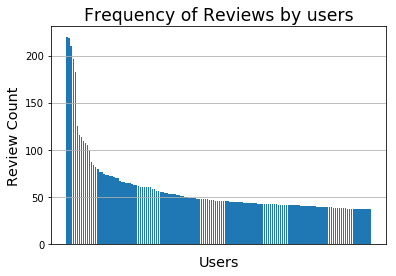

In [22]:
#Review frequency of users
#NOTE: The data is already sorted by the number of reviews (#rating)
plt.bar(np.arange(len(review_cnt['customer_id'][:150])), review_cnt['#rating'][:150], tick_label ='')

plt.grid(axis = 'y')
plt.tick_params(bottom= False, )
plt.xlabel("Users", fontsize = 'x-large')
plt.ylabel("Review Count", fontsize = 'x-large')
plt.title("Frequency of Reviews by users", fontsize = 'xx-large')

plt.show()

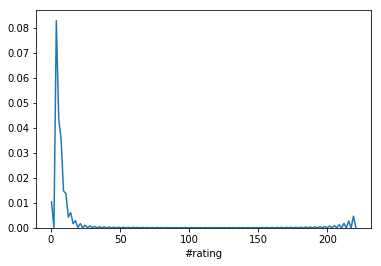

In [42]:
import seaborn as sns

sns.distplot(review_cnt['#rating'], hist=False, kde=True)

We can see that most of the movies have alot less than 50 reviews and the density plot is pretty skewed.

Let's see how the average rating of the top movies changed overtime.

In [43]:
#Set index to the finaldf to slice according to the top10new dataframe we found above
finaldf = finaldf.set_index('title')

#Keep the information about only the top10 movies
top10df = finaldf[finaldf.index.isin(top10new.index)]

In [44]:
top10df = top10df.reset_index()

top10df['date'] = pd.to_datetime(top10df['date'])

first = top10df[top10df['title'].map(lambda x: 'Chappelle' in x)]\
        .groupby(['title', 'date'], as_index=False).agg({'rating' : 'mean'})\
        .sort_values('date', ascending=True)

second = top10df[top10df['title'].map(lambda x: 'Aqua' in x)]\
        .groupby(['title', 'date'], as_index=False).agg({'rating' : 'mean'})\
        .sort_values('date', ascending=True)

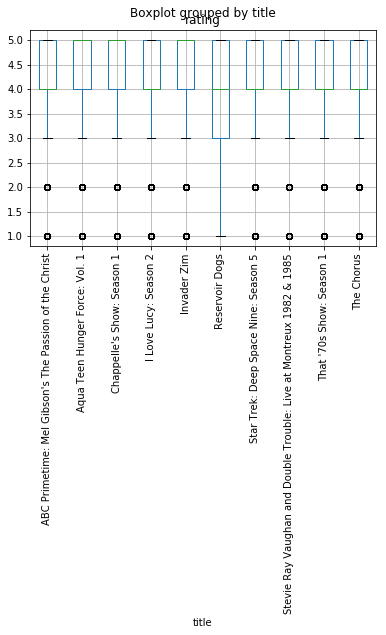

In [55]:
top10df.boxplot(column='rating', by='title')
plt.xticks(rotation=90)
plt.show()

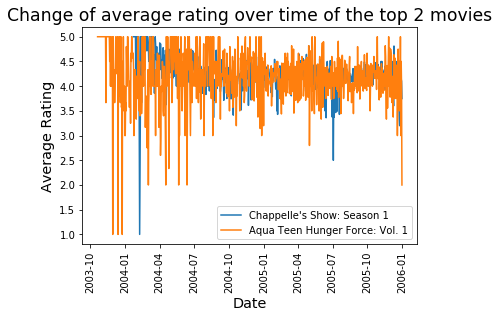

In [46]:
#plot the change over time
firstplt = plt.plot(first['date'], first['rating'], label = first['title'][0])
secondplt = plt.plot(second['date'], second['rating'], label = second['title'][0])

plt.xticks(rotation='vertical')
plt.xlabel("Date", fontsize = 'x-large')
plt.ylabel("Average Rating", fontsize = 'x-large')
plt.title("Change of average rating over time of the top 2 movies", fontsize = 'xx-large')
plt.legend()

plt.show()